# System Dynamics
Parameters:

- $ r $: Radius of the wheels
- $ L $: Distance from wheel to wheel (half the body width)

State Variables:

- $ x $: $ x $-position of the rover's center of mass
- $ y $: $ y $-position of the rover's center of mass
- $ \psi $: Absolute heading angle of the rover (orientation of the body)
- $ \phi_L $: Absolute angle of rotation of the left wheel
- $ \phi_R $: Absolute angle of rotation of the right wheel

Inputs:

- $ \dot{\phi}_L $: Angular velocity of the left wheel
- $ \dot{\phi}_R $: Angular velocity of the right wheel

The system of differential equations describing the rover is:
$$
\begin{align}
\dot{x} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \cos(\psi) \\
\dot{y} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \sin(\psi) \\
\dot{\psi} &= \frac{r}{L} (\dot{\phi}_R - \dot{\phi}_L) \\
\dot{\phi}_L &= u_L \\
\dot{\phi}_R &= u_R
\end{align}
$$

We define our state and input vectors as follows:
$$
q = \begin{bmatrix}
            x \\
            y \\
            \psi \\
            \phi_L \\
            \phi_R
        \end{bmatrix}, 
u = \begin{bmatrix}
        u_L \\
        u_R
    \end{bmatrix} 
    = \begin{bmatrix}
        \dot{\phi}_L \\
        \dot{\phi}_R
    \end{bmatrix} 
$$

The continuous time state space dynamics are:
$$ 
\begin{align}
\dot{q} &= f(q, u) \\
        &= \begin{bmatrix}
                \frac{r}{2} \cos(\psi) & \frac{r}{2} \cos(\psi) \\
                \frac{r}{2} \sin(\psi) & \frac{r}{2} \sin(\psi) \\
                -\frac{r}{L} & \frac{r}{L} \\
                1 & 0 \\
                0 & 1
            \end{bmatrix} 
            \begin{bmatrix}
                u_L \\
                u_R
            \end{bmatrix} 
\end{align}
$$

We can discretize the system:
$$
\begin{align}
    q_{k+1} &= q_k + T_s f(q_k, u_k) \\
            &= q_k + T_s \begin{bmatrix}
                            \frac{r}{2} \cos(\psi) & \frac{r}{2} \cos(\psi) \\
                            \frac{r}{2} \sin(\psi) & \frac{r}{2} \sin(\psi) \\
                            -\frac{r}{L} & \frac{r}{L} \\
                            1 & 0 \\
                            0 & 1
                        \end{bmatrix} 
                        \begin{bmatrix}
                            u_L \\
                            u_R
                        \end{bmatrix} 
\end{align}
$$


# Functions

#### CFTOC Function definition

In [14]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

# GLOBAL VARIABLES
r_cm = 3   # cm 
L_cm = 20  # cm
Ts = 0.1   # s

#Solves a CFTOC problem
def solve_cftoc(nq, nu, P, Q, R, N, q0, qL, qU, uL, uU, bf, Af, qref, uref):
  """
  Solves a CFTOC problem
    q_ref, u_ref: reference trajectory, should be of length N, of size nq and nu respectively
  
  """
  model = pyo.ConcreteModel()
  model.N = N                   # number of steps
  model.nq = nq                 # number of states
  model.nu = nu                 # number of inputs
  model.nf = np.size(Af, 0)     # number of terminal states

  # length of finite optimization problem:
  model.tIDX = pyo.Set(initialize= range(model.N+1), ordered=True)
  model.qIDX = pyo.Set(initialize= range(model.nq), ordered=True)
  model.uIDX = pyo.Set(initialize= range(model.nu), ordered=True)
  model.nfIDX = pyo.Set(initialize= range(model.nf), ordered=True)

  model.q = pyo.Var(model.qIDX, model.tIDX)
  model.u = pyo.Var(model.uIDX, model.tIDX)

  model.P = P; model.Q = Q; model.R = R
  model.Af = Af; model.Bf = bf

  
  #This function returns the instantaneous value of the i-th element of the state vector, at time t
  #This is the continuous time dynamics, q_dot = f(x,u)
  def sysDyn_CT_qdot(model, i, t):
    global r_cm, L_cm, Ts
    psi_k = model.q[2,t]

    B_k = np.array([[r_cm/2*pyo.cos(psi_k), r_cm/2*pyo.cos(psi_k)],
              [r_cm/2*pyo.sin(psi_k), r_cm/2*pyo.sin(psi_k)],
              [-r_cm/L_cm, r_cm/L_cm],
              [1, 0],
              [0, 1]])
    
    return (B_k[i,0] * model.u[0,t] + B_k[i,1] * model.u[1,t])

  #This function returns the k+1 value of the i-th element of the state vector at time t
  #This is the discrete time dynamics, q_{k+1} = q_k + Ts * f(q_k,u_k), where q_dot = f(q,u)
  def sysDyn_disc_kplus1(model, i, t):
    global r_cm, L_cm, Ts
    return model.q[i,t] + Ts * sysDyn_CT_qdot(model, i, t)
    
  # def B_k(model, t):
  #   global r_cm, L_cm, Ts
  #   psi_k = model.q[2,t]
  #   B_k = np.array([[r_cm/2*pyo.cos(psi_k), r_cm/2*pyo.cos(psi_k)],
  #             [r_cm/2*pyo.sin(psi_k), r_cm/2*pyo.sin(psi_k)],
  #             [-r_cm/L_cm, r_cm/L_cm],
  #             [1, 0],
  #             [0, 1]])
  #   return B_k * Ts

  def dynamics_constraints(model, i, t):
    # B = B_k(model, t)
    # return model.q[i, t+1] - (model.q[i,t] + sum(B[i,j]*model.u[j,t] for j in model.uIDX)) == 0.0 if t < model.N else pyo.Constraint.Skip
    return model.q[i, t+1] - sysDyn_disc_kplus1(model, i, t) == 0.0 if t < model.N else pyo.Constraint.Skip
  
  def final_constraints(model, i):
    return sum(model.Af[i,j]*model.q[j,model.N] for j in model.qIDX) <= model.Bf[i]

  model.dynamics_constraints = pyo.Constraint(model.qIDX, model.tIDX, rule=dynamics_constraints)
  model.init_constraints = pyo.Constraint(model.qIDX, rule = lambda model, i: model.q[i,0] == q0[i])
  model.terminal_constraints = pyo.Constraint(model.nfIDX, rule = final_constraints)

  # State and input constraints
  model.qL_constraints = pyo.Constraint(model.qIDX, model.tIDX, rule = lambda model, i, t: model.q[i,t] >= qL[i])
  model.qU_constraints = pyo.Constraint(model.qIDX, model.tIDX, rule = lambda model, i, t: model.q[i,t] <= qU[i])
  model.uL_constraints = pyo.Constraint(model.uIDX, model.tIDX, rule = lambda model, i, t: model.u[i,t] >= uL[i])
  model.uU_constraints = pyo.Constraint(model.uIDX, model.tIDX, rule = lambda model, i, t: model.u[i,t] <= uU[i])

  def objective_rule(model):
    costQ = 0.0
    costU = 0.0
    costTerminal = 0.0

    # We need to use qref/uref[t-1] because we don't use the control at time 0
    for t in model.tIDX:
      for i in model.qIDX:
        for j in model.qIDX:
          if t < model.N:
            costQ += (model.q[i,t]-qref[i,t]) * model.Q[i,j] * (model.q[j,t]-qref[j,t])
    for t in model.tIDX:
      for i in model.uIDX:
        for j in model.uIDX:
          if t < model.N:
            costU += (model.u[i,t]-uref[i,t]) * model.R[i,j] * (model.u[j,t]-uref[i,t])
    for i in model.qIDX:
      for j in model.qIDX:
        costTerminal += (model.q[i,model.N]-qref[i,model.N]) * model.P[i,j] * (model.q[j,model.N]-qref[i,model.N])
        
    return costQ + costU + costTerminal

  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)

  feas = str(results.solver.termination_condition) == "optimal"
  xOpt = np.asarray([[model.q[i,t]() for i in model.qIDX] for t in model.tIDX]).T
  uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
  JOpt = model.cost()

  return [feas, xOpt, uOpt, JOpt, model, results]


In [15]:
def checkKKT(model, results, obj_grad, g, b):
  threshold = 1e-5

  #Show the objective
  print("Objective")
  print(f"\t {model.obj.expr}")

  #Get the dual values (u_star)
  u_star = []
  print("Constraints:")
  for constraint in model.component_objects(pyo.Constraint):
    print(f"\t {constraint.expr}")
    u = -model.dual[constraint]
    if np.abs(u) < threshold:
      u = 0
    u_star.append(u)
  u_star = np.asarray(u_star)

  #Get the optimizer value (z_star)
  z_star = np.array([pyo.value(model.z[i]) for i in range(len(model.z))])
  print(f"Optimizer values, z_star = {z_star}")
  print(f"Dual values, u_star = {u_star}")

  #Check primal feasibility
  flag_pf = np.all(g@z_star + b <= 0)

  #Check Dual feasibility
  flag_df = np.all(u_star >= 0)

  #Check complementary slackness
  flag_cs = np.all(np.abs(np.multiply(u_star, (g@z_star + b))) < threshold)

  #Check Stationary Lagrangian
  flag_sl = np.all( np.abs( obj_grad + g.T@u_star ) < threshold )

  KKT_status = flag_pf and flag_df and flag_cs and flag_sl
  print(f"KKT status = {KKT_status}")
  print(f"\tStationary Lagrangian = {flag_sl}")
  print(f"\tComplementary Slackness = {flag_cs}")
  print(f"\tDual feasibility = {flag_df}")
  print(f"\tPrimal Feasibility = {flag_pf}")

  return KKT_status



# Simulations/Animations

### Batch optimization for trajectory generation

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Optimal cost = 1112.7135115968827
[-0.48676 -0.42548  0.01962  0.01745 -0.01745]
False


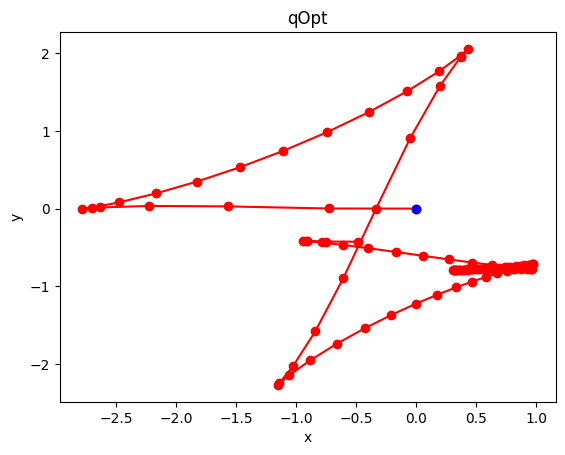

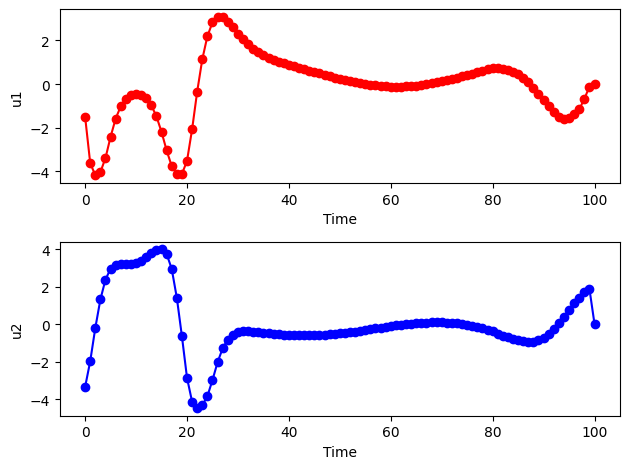

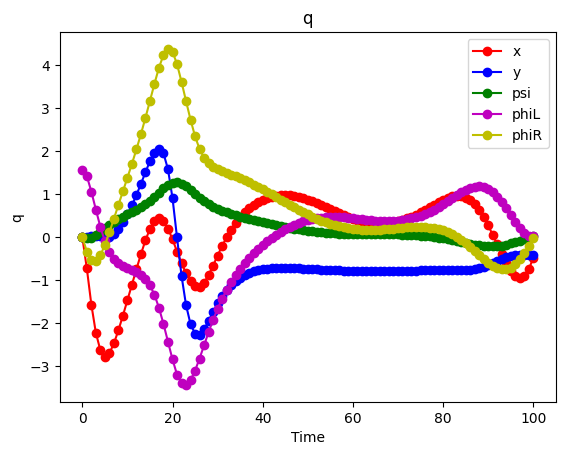

In [21]:
def batch_trajectory(N):
    nq = 5
    nu = 2
    P = np.eye(5)
    # Q = np.diag([1, 2, 2, 3, 3])
    Q = np.eye(5)
    R = np.eye(5)

    q0 = np.array([0, 0, 0, np.pi/2, 0])

    # State constraints
    qL = np.array([-100, -100, -np.inf, -np.inf, -np.inf])
    qU = np.array([100, 100, np.inf, np.inf, np.inf])
    uL = np.array([-1, -1])* 2*np.pi             #Max wheel rotation speed in rad/s
    uU = np.array([1, 1]) * 2*np.pi

    # Final state constraints
    phi_final = 0       #THIS IS NOT DEFINED RIGHT, is a polytope centered at 0 now with Aq <= b, need affine polytope
    x_final_bound = 0.5
    y_final_bound = 0.5
    psi_final_bound = np.deg2rad(1)
    phi_final_bound = np.deg2rad(1)
    Af = np.vstack((np.eye(5), -np.eye(5)))
    bf = np.array([x_final_bound, y_final_bound, psi_final_bound, phi_final_bound, phi_final_bound,       # upper bounds
                   x_final_bound, y_final_bound, psi_final_bound, phi_final_bound, phi_final_bound])      # lower bounds
    qref = np.zeros((5, 1001))
    uref = np.zeros((2, 1001))
    
    [feas, qOpt, uOpt, JOpt, model, results] = solve_cftoc(nq, nu, P, Q, R, N, q0, qL, qU, uL, uU, bf, Af, qref, uref)
    print(f"Optimal cost = {JOpt}")
    # model.pprint()

    # Check the KKT conditions

    return qOpt, uOpt, N, feas



[q_traj_batch, u_traj_batch, N_batch, feas] = batch_trajectory(100)
#print out the final state
print(q_traj_batch[:,-1])
print(feas)


plt.figure()
plt.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'ro-')
# Show the initial x,y position
plt.plot(q_traj_batch[0,0], q_traj_batch[1,0], 'bo')

plt.xlabel('x')
plt.ylabel('y')
plt.title('qOpt')

# Plot inputs in two subplots
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(N_batch+1), u_traj_batch[0,:], 'ro-')
plt.xlabel('Time')
plt.ylabel('u1')

plt.subplot(2,1,2)
plt.plot(range(N_batch+1), u_traj_batch[1,:], 'bo-')
plt.xlabel('Time')
plt.ylabel('u2')
plt.tight_layout()


# Plot all states
plt.figure()
plt.plot(range(N_batch+1), q_traj_batch[0,:], 'ro-', label='x')
plt.plot(range(N_batch+1), q_traj_batch[1,:], 'bo-', label='y')
plt.plot(range(N_batch+1), q_traj_batch[2,:], 'go-', label='psi')
plt.plot(range(N_batch+1), q_traj_batch[3,:], 'mo-', label='phiL')
plt.plot(range(N_batch+1), q_traj_batch[4,:], 'yo-', label='phiR')
plt.xlabel('Time')
plt.ylabel('q')
plt.title('q')
plt.legend()



In [17]:
print(q_traj_batch[3, :])
print(u_traj_batch[0, :])
print(u_traj_batch[1, :])


[ 1.5703   0.94173  0.31308  0.46766  0.97353  0.34513 -0.28327 -0.91171
 -0.70025 -0.38171  0.13452]
[-6.28319 -6.28319  1.91802  5.761   -6.28319 -6.28319 -6.28319  5.56624
  6.28319  6.28319 -0.     ]
[-6.10865  6.28319  6.28319  6.28319  6.28319  6.28319 -6.28319 -6.28319
 -6.28319 -6.28319 -0.     ]


### MPC
Simulate the MPC 1 step at a time

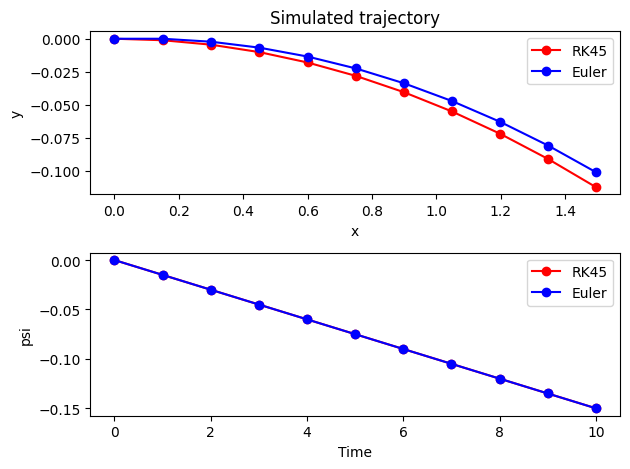

In [18]:
from scipy.integrate import solve_ivp

# Function to discretize the continuous time dynamics, using Runge-Kutta integration
def sysDyn_sim_RK_kplus1(q_k, u_k, r, L):
    global Ts
    def continuous_dynamics(t, q_k, u_k, r, L):
      x_k, y_k, psi_k, phiL_k, phiR_k = q_k

      B = np.array([[r/2*np.cos(psi_k), r/2*np.cos(psi_k)],
                    [r/2*np.sin(psi_k), r/2*np.sin(psi_k)],
                    [-r/L, r/L],
                    [1, 0],
                    [0, 1]])

      dqdt = B @ u_k
      return dqdt

    t_span = [0, Ts]
    
    # Using solve_ivp to integrate using 'RK45' (Runge-Kutta-Fehlberg)
    sol = solve_ivp(continuous_dynamics, t_span, q_k, args=(u_k, r, L), method='RK45')

    q_kplus1 = sol.y[:, -1]  # final state at time Ts
    return q_kplus1

# Function to discretize the continuous time dynamics, using Euler discretization
def sysDyn_sim_euler_kplus1(q_k, u_k, r, L):
    global Ts
    x_k, y_k, psi_k, phiL_k, phiR_k = q_k

    B = np.array([[r/2*np.cos(psi_k), r/2*np.cos(psi_k)],
                  [r/2*np.sin(psi_k), r/2*np.sin(psi_k)],
                  [-r/L, r/L],
                  [1, 0],
                  [0, 1]])

    q_kplus1 = q_k + (B @ u_k) * Ts
    return q_kplus1


#Compare the two methods by simulating the system
M_sim = 10
q0 = np.array([0, 0, 0, np.pi/2, 0])
q_sim_RK = np.zeros((5, M_sim+1))
q_sim_euler = np.zeros((5, M_sim+1))
q_sim_RK[:, 0] = q0
q_sim_euler[:, 0] = q0

#Use test inputs
u_test = np.zeros((2, M_sim))
u_test[0, :] = 1

for k in range(M_sim):
    q_sim_RK[:, k+1] = sysDyn_sim_RK_kplus1(q_sim_RK[:, k], u_test[:, k], r_cm, L_cm)
    q_sim_euler[:, k+1] = sysDyn_sim_euler_kplus1(q_sim_euler[:, k], u_test[:, k], r_cm, L_cm)

# Plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(q_sim_RK[0,:], q_sim_RK[1,:], 'ro-', label='RK45')
plt.plot(q_sim_euler[0,:], q_sim_euler[1,:], 'bo-', label='Euler')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated trajectory')
plt.legend()

plt.subplot(2,1,2)
plt.plot(range(M_sim+1), q_sim_RK[2,:], 'ro-', label='RK45')
plt.plot(range(M_sim+1), q_sim_euler[2,:], 'bo-', label='Euler')
plt.xlabel('Time')
plt.ylabel('psi')
plt.legend()
plt.tight_layout()




#### Simulate the full control system
1) Batch optimization to find trajectory to follow
2) MPC to follow path.  Simulate 1 step at a time and record.

In [39]:
M_sim = 100
q0 = np.array([0, 0, 0, np.pi/2, 0])

# 1) Batch trajectory calculation
[q_traj_batch, u_traj_batch, N_batch, feas] = batch_trajectory(M_sim)

# 2) Simulate the system using the optimal inputs
N = 5
nq = 5
nu = 2
P = np.eye(5)
Q = np.eye(5)
R = np.eye(2)

q0 = np.array([0, 0, 0, np.pi/2, 0])
qL = np.array([-100, -100, -np.inf, -np.inf, -np.inf])
qU = np.array([100, 100, np.inf, np.inf, np.inf])
uL = np.array([-1, -1])* 2*np.pi             #Max wheel rotation speed in rad/s
uU = np.array([1, 1]) * 2*np.pi

# pad the trajectory with N zeros
q_traj_batch = np.hstack((q_traj_batch, np.zeros((nq, N+1))))
u_traj_batch = np.hstack((u_traj_batch, np.zeros((nu, N+1))))

# Create variables to store the simulated trajectory
q_MPC = np.zeros((nq, M_sim+1))
q_MPC_openloop = np.zeros((nq, M_sim+1, N+1))
u_MPC = np.zeros((nu, M_sim))
q_MPC[:, 0] = q0

# Simulate the system
for t in range(M_sim):
    # Get the reference trajectory from the batch optimization
    qref = q_traj_batch[:, t:t+N+1]
    uref = u_traj_batch[:, t:t+N+1]

    # The final state constraints are the last state of the reference trajectory
    bf = np.concatenate((qref[:,-1], qref[:,-1]))
    Af = np.vstack((np.eye(nq), -np.eye(nq)))

    [feas, qOpt, uOpt, JOpt, model, results] = solve_cftoc(nq, nu, P, Q, R, N, q_MPC[:,t], qL, qU, uL, uU, bf, Af, qref, uref)
    
    # Update the initial state for the next iteration
    u_MPC[:, t] = uOpt[:, 0]
    q_MPC[:, t+1] = sysDyn_sim_RK_kplus1(q_MPC[:, t], u_MPC[:, t], r_cm, L_cm)

    # Store the open-loop trajectories
    q_MPC_openloop[:, t, :] = qOpt




model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Optimal cost = 1102.1528311681668
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible

#### Plotting

Final state: [-0.06715  0.34379  0.18054  0.3672   0.     ]


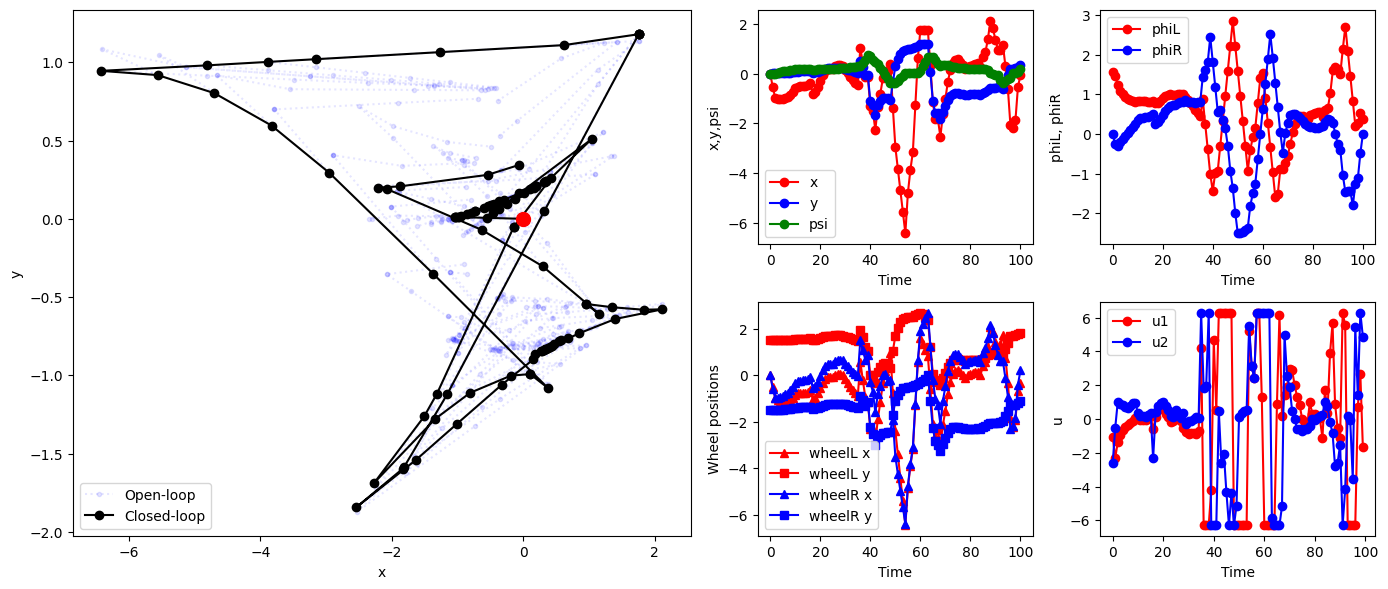

In [46]:
# Print the final state
print(f"Final state: {q_MPC[:, -1]}")


# Plot the closed-loop trajectory and the open-loop trajectories
# Also show the states in subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Large square axes
ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2, rowspan=2)  # Spans all three rows in the first column

# Four smaller plots in a 2x2 grid on the side
ax2 = plt.subplot2grid((2, 4), (0, 2))  # First row, second column
ax3 = plt.subplot2grid((2, 4), (0, 3))  # First row, third column
ax4 = plt.subplot2grid((2, 4), (1, 2))  # Second row, second column
ax5 = plt.subplot2grid((2, 4), (1, 3))  # Second row, third column

for t in range(M_sim):
    open_loop = ax1.plot(q_MPC_openloop[0, t, :], q_MPC_openloop[1, t, :], 'b:.', alpha=0.1)

closed_loop = ax1.plot(q_MPC[0,:], q_MPC[1,:], 'ko-', label='Closed-loop')
ax1.plot(q0[0], q0[1], 'ro', markersize=10) # Show the initial position
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend([open_loop[0], closed_loop[0]],['Open-loop','Closed-loop'])


#Position and heading
ax2.plot(range(M_sim+1), q_MPC[0,:], 'ro-', label='x')
ax2.plot(range(M_sim+1), q_MPC[1,:], 'bo-', label='y')
ax2.plot(range(M_sim+1), q_MPC[2,:], 'go-', label='psi')
ax2.set_xlabel('Time')
ax2.set_ylabel('x,y,psi')
ax2.legend()

#Wheel angles
ax3.plot(range(M_sim+1), q_MPC[3,:], 'ro-', label='phiL')
ax3.plot(range(M_sim+1), q_MPC[4,:], 'bo-', label='phiR')
ax3.set_xlabel('Time')
ax3.set_ylabel('phiL, phiR')
ax3.legend()

#Wheel positions over time
wheelL_pos = q_MPC[0:2, :] + r_cm/2 *np.array([np.cos(q_MPC[2, :] + np.pi/2), np.sin(q_MPC[2, :] + np.pi/2)])
wheelR_pos = q_MPC[0:2, :] - r_cm/2 *np.array([np.cos(q_MPC[2, :] + np.pi/2), np.sin(q_MPC[2, :] + np.pi/2)])
ax4.plot(range(M_sim+1), wheelL_pos[0,:], 'r^-', label='wheelL x')
ax4.plot(range(M_sim+1), wheelL_pos[1,:], 'rs-', label='wheelL y')
ax4.plot(range(M_sim+1), wheelR_pos[0,:], 'b^-', label='wheelR x')
ax4.plot(range(M_sim+1), wheelR_pos[1,:], 'bs-', label='wheelR y')
ax4.set_xlabel('Time')
ax4.set_ylabel('Wheel positions')
ax4.legend()

#Inputs
ax5.plot(range(M_sim), u_MPC[0,:], 'ro-', label='u1')
ax5.plot(range(M_sim), u_MPC[1,:], 'bo-', label='u2')
ax5.set_xlabel('Time')
ax5.set_ylabel('u')
ax5.legend()

plt.tight_layout()


In [ ]:
def MPC(A, B, P, Q, R, N, M, q0, qL, qU, uL, uU, bf, Af, plot):
  nq = np.size(A, 0)
  nu = np.size(B, 1)

  qOpt = np.zeros((nq, M+1))
  qOpt[:,0] = q0.reshape(nq, )
  uOpt = np.zeros((nu, M))

  predErr = np.zeros((nq, M))

  feas = np.zeros((M, ), dtype = bool)
  qN = np.zeros((nq,))

  for t in range(M):
    [feas[t], q, u, J] = solve_cftoc(A, B, P, Q, R, N, qOpt[:,t], qL, qU, uL, uU, bf, Af)

    if not feas[t]:
      qOpt = []
      uOpt = []
      predErr = []
      break

    # closed loop trajectory
    qOpt[:,t+1] = q[:,1]
    uOpt[:,t] = u[:,0].reshape(nu, )
    predErr[:,t] = qN - q[:,1]
  return feas, qOpt, uOpt, predErr


In [ ]:
def simulate_rover(z0, u, N, r, L):
    trajectory = [z0]
    timesteps = range(N)
    for t in timesteps:
        trajectory.append(sim_RoverDynamics_kplus1(trajectory[-1], u[t], r, w))

    trajectory = np.array(trajectory)
    x_traj, y_traj, psi_traj, phiL_traj, phiR_traj = trajectory.T

    # wheel positions
    wheelL_pos = np.array([x_traj, y_traj]).T + (L/2)*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T
    wheelR_pos = np.array([x_traj, y_traj]).T - (L/2)*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T

    return trajectory, wheelL_pos, wheelR_pos
